# Hypothesis 1: The autoreg model distinguishes between answerable and unanswerable questions

In [75]:
import csv
import matplotlib
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline  

In [5]:
losses = []
with open("results/losses.csv", "r") as handle:
    reader = csv.reader(handle)
    for row in reader:
        losses.append(row)

In [7]:
ans_losses = [float(x[1]) for x in losses if x[2] == 'ANS']
unans_losses = [float(x[1]) for x in losses if x[2] == 'UNANS']

In [10]:
print(np.mean(ans_losses))
print(np.mean(unans_losses))

0.010899549386591
0.011600911090913392


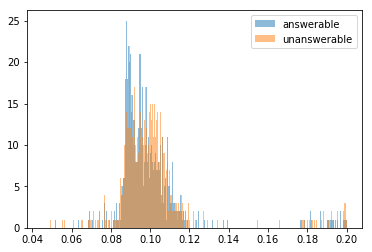

In [52]:
#bins = np.linspace(.00000001, .000025, 300)
bins = np.linspace(.045, .2, 300)
plt.hist(ans_losses, bins, alpha=0.5, label='answerable')
plt.hist(unans_losses, bins, alpha=0.5, label='unanswerable')
plt.legend(loc='upper right')
plt.show()

In [38]:
np.mean(ans_losses[:16*40])

0.007729313976597041

In [39]:
np.mean(unans_losses[:16*40])

0.00874836976872757

In [40]:
np.sum(ans_losses[:16*40])

4.946760945022106

In [41]:
np.sum(unans_losses[:16*40])

5.598956651985645

In [55]:
stops = np.linspace(1, 6000, 300)

In [59]:
ans_prog = []
unans_prog = []
xes = []
for x in np.round(stops):
    x = int(x)
    xes.append(x)
    ans_prog.append(np.sum(ans_losses[:x]))
    unans_prog.append(np.sum(unans_losses[:x]))

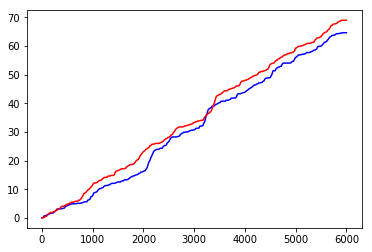

In [65]:
plt.plot(xes, ans_prog, color='blue')
plt.plot(xes, unans_prog, color='red')

In [68]:
print(np.mean([l for l in ans_losses if l > 0.04]))
print(np.mean([l for l in unans_losses if l > 0.04]))

0.10109114591543816
0.10232666909467172


In [69]:
print(np.mean([l for l in ans_losses if l < 0.04]))
print(np.mean([l for l in unans_losses if l < 0.04]))

0.00038370869128936247
0.0003673815082174168


In [70]:
from pytorch_pretrained_bert.tokenization import BertTokenizer

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [71]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [76]:
with open("dataset/dev-v2.0.json", 'r') as handle:
    jdata = json.load(handle)
    data = jdata['data']

id2q = {}
for i in range(len(data)):
    section = data[i]['paragraphs']
    for sec in section:
        qas = sec['qas']
        for j in range(len(qas)):
            question = qas[j]['question']
            unanswerable = qas[j]['is_impossible']
            id = qas[j]['id']
            id2q[id] = question

In [77]:
for i, l, tag in losses:
    assert i in id2q

In [79]:
adjusted_losses = []
for idx, l, tag in losses:
    l = float(l)
    qlen = len(tokenizer.tokenize(id2q[idx]))
    adjusted_losses.append([idx, l / qlen, tag])

In [82]:
ans_losses = [float(x[1]) for x in adjusted_losses if x[2] == 'ANS']
unans_losses = [float(x[1]) for x in adjusted_losses if x[2] == 'UNANS']

In [83]:
print(np.mean(ans_losses))
print(np.mean(unans_losses))

0.0008983249290571931
0.0010332992713177405


In [84]:
print(np.min(ans_losses + unans_losses))
print(np.max(ans_losses + unans_losses))

3.14580069647895e-08
0.027308174542018344


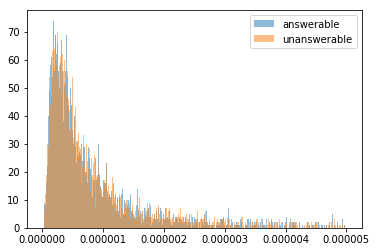

In [98]:
bins = np.linspace(0, .000005, 500)
plt.hist(ans_losses, bins, alpha=0.5, label='answerable')
plt.hist(unans_losses, bins, alpha=0.5, label='unanswerable')
plt.legend(loc='upper right')
plt.show()

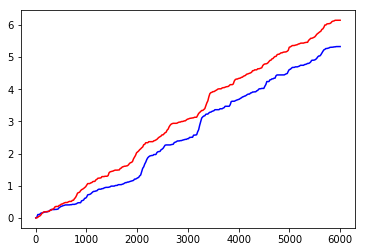

In [101]:
ans_prog = []
unans_prog = []
xes = []
for x in np.round(stops):
    x = int(x)
    xes.append(x)
    ans_prog.append(np.sum(ans_losses[:x]))
    unans_prog.append(np.sum(unans_losses[:x]))
plt.plot(xes, ans_prog, color='blue')
plt.plot(xes, unans_prog, color='red')

In [102]:
with open("dataset/dev-v2.0.json", 'r') as handle:
    jdata = json.load(handle)
    data = jdata['data']

id2q = {}
for i in range(len(data)):
    section = data[i]['paragraphs']
    for sec in section:
        context = sec['context']
        qas = sec['qas']
        for j in range(len(qas)):
            question = qas[j]['question']
            unanswerable = qas[j]['is_impossible']
            id = qas[j]['id']
            id2q[id] = (question, context)

In [121]:
from collections import Counter

In [124]:
ans_loss_counter = Counter({x[0]:float(x[1]) for x in adjusted_losses if x[2] == 'ANS'})
unans_loss_counter = Counter({x[0]:float(x[1]) for x in adjusted_losses if x[2] == 'UNANS'})

In [127]:
for idx, loss in ans_loss_counter.most_common()[:5]:
    print("loss:", loss)
    print("context:\n", id2q[idx][1])
    print("~"*20)
    print("question:\n", id2q[idx][0])
    print("#"*20)

loss: 0.0210401713848114
context:
 The Normans were in contact with England from an early date. Not only were their original Viking brethren still ravaging the English coasts, they occupied most of the important ports opposite England across the English Channel. This relationship eventually produced closer ties of blood through the marriage of Emma, sister of Duke Richard II of Normandy, and King Ethelred II of England. Because of this, Ethelred fled to Normandy in 1013, when he was forced from his kingdom by Sweyn Forkbeard. His stay in Normandy (until 1016) influenced him and his sons by Emma, who stayed in Normandy after Cnut the Great's conquest of the isle.
~~~~~~~~~~~~~~~~~~~~
question:
 Who did Emma Marry?
####################
loss: 0.01971820294857025
context:
 The efficiency of a Rankine cycle is usually limited by the working fluid. Without the pressure reaching supercritical levels for the working fluid, the temperature range the cycle can operate over is quite small; in ste

In [128]:
for idx, loss in unans_loss_counter.most_common()[:5]:
    print("loss:", loss)
    print("context:\n", id2q[idx][1])
    print("~"*20)
    print("question:\n", id2q[idx][0])
    print("#"*20)

loss: 0.027308174542018344
context:
 Jacksonville is in the First Coast region of northeast Florida and is centered on the banks of the St. Johns River, about 25 miles (40 km) south of the Georgia state line and about 340 miles (550 km) north of Miami. The Jacksonville Beaches communities are along the adjacent Atlantic coast. The area was originally inhabited by the Timucua people, and in 1564 was the site of the French colony of Fort Caroline, one of the earliest European settlements in what is now the continental United States. Under British rule, settlement grew at the narrow point in the river where cattle crossed, known as Wacca Pilatka to the Seminole and the Cow Ford to the British. A platted town was established there in 1822, a year after the United States gained Florida from Spain; it was named after Andrew Jackson, the first military governor of the Florida Territory and seventh President of the United States.
~~~~~~~~~~~~~~~~~~~~
question:
 What cities 340 km from Jacksonv

In [129]:
for idx, loss in ans_loss_counter.most_common()[-5:]:
    print("loss:", loss)
    print("context:\n", id2q[idx][1])
    print("~"*20)
    print("question:\n", id2q[idx][0])
    print("#"*20)

loss: 4.6359168158637154e-08
context:
 With Istanbul as its capital and control of lands around the Mediterranean basin, the Ottoman Empire was at the center of interactions between the Eastern and Western worlds for six centuries. Following a long period of military setbacks against European powers, the Ottoman Empire gradually declined into the late nineteenth century. The empire allied with Germany in the early 20th century, with the imperial ambition of recovering its lost territories, but it dissolved in the aftermath of World War I, leading to the emergence of the new state of Turkey in the Ottoman Anatolian heartland, as well as the creation of modern Balkan and Middle Eastern states, thus ending Turkish colonial ambitions.
~~~~~~~~~~~~~~~~~~~~
question:
 What was the capital of the Ottoman empire?
####################
loss: 4.6193599700927736e-08
context:
 However, in 1883–84 Germany began to build a colonial empire in Africa and the South Pacific, before losing interest in imp

In [130]:
for idx, loss in unans_loss_counter.most_common()[-5:]:
    print("loss:", loss)
    print("context:\n", id2q[idx][1])
    print("~"*20)
    print("question:\n", id2q[idx][0])
    print("#"*20)

loss: 4.842877388000488e-08
context:
 In World War II, it was recognised that the Rhine would present a formidable natural obstacle to the invasion of Germany, by the Western Allies. The Rhine bridge at Arnhem, immortalized in the book, A Bridge Too Far and the film, was a central focus of the battle for Arnhem, during the failed Operation Market Garden of September 1944. The bridges at Nijmegen, over the Waal distributary of the Rhine, were also an objective of Operation Market Garden. In a separate operation, the Ludendorff Bridge, crossing the Rhine at Remagen, became famous, when U.S. forces were able to capture it intact – much to their own surprise – after the Germans failed to demolish it. This also became the subject of a film, The Bridge at Remagen. Seven Days to the River Rhine was a Warsaw Pact war plan for an invasion of Western Europe during the Cold War.
~~~~~~~~~~~~~~~~~~~~
question:
 How long did the Cold War last?
####################
loss: 4.6566128730773926e-08
conte